<a href="https://colab.research.google.com/github/edwin-19/ocr_exploration/blob/main/TableTranformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00


In [33]:
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from matplotlib import pyplot as plt
import io
import requests
from PIL import Image, ImageFont
import numpy as np

In [3]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

image_processor_struct = AutoImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model_struct = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [10]:
url = "https://marketplace.canva.com/EAFC1OcYOM0/2/0/1131w/canva-black-white-minimalist-simple-creative-freelancer-invoice-pyLVaYlAk1o.jpg"
r = requests.get(url, stream=True)
if r.status_code == 200:
    img = Image.open(io.BytesIO(r.content))

In [5]:
inputs = image_processor(images=img, return_tensors="pt")
outputs = model(**inputs)

In [6]:
target_sizes = torch.tensor([img.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

In [7]:
from PIL import ImageDraw

In [20]:
draw = ImageDraw.Draw(img)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.type(torch.long).tolist()]

    # draw.rectangle(tuple(box), outline="red")
    print(model.config.id2label[label.item()])
    print(box)

table
[113, 297, 1013, 1156]


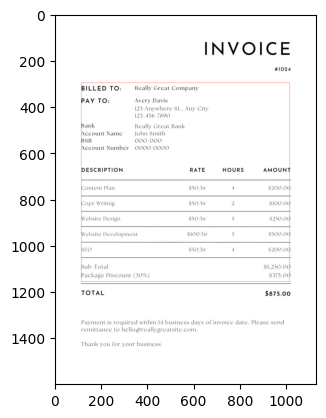

In [9]:
plt.imshow(img)

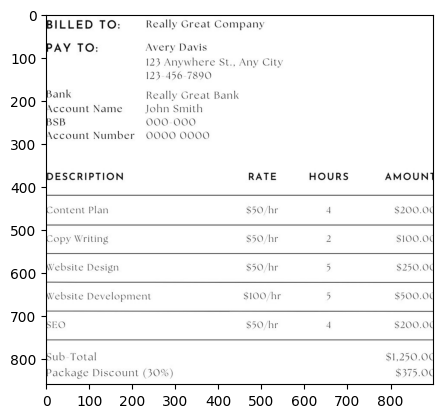

In [21]:
cropped_img = np.array(img)[box[1]:box[3], box[0]:box[2]]
plt.imshow(cropped_img)

In [23]:
inputs = image_processor_struct(images=cropped_img, return_tensors="pt")
outputs = model_struct(**inputs)

In [26]:
target_sizes = torch.tensor([Image.fromarray(cropped_img).size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

In [36]:
crop_img = Image.fromarray(cropped_img)
draw = ImageDraw.Draw(crop_img)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.type(torch.long).tolist()]

    draw.rectangle(tuple(box), outline="red")

    # Add text inside the rectangle:
    text_x = box[0] + 5  # Adjust text position as needed
    text_y = box[1] - 10  # Adjust text position as needed
    font = ImageFont.load_default()  # Choose your preferred font and size
    draw.text((text_x, text_y), f"{model_struct.config.id2label[label.item()]}: {score:.2f}", fill="black", font=font)

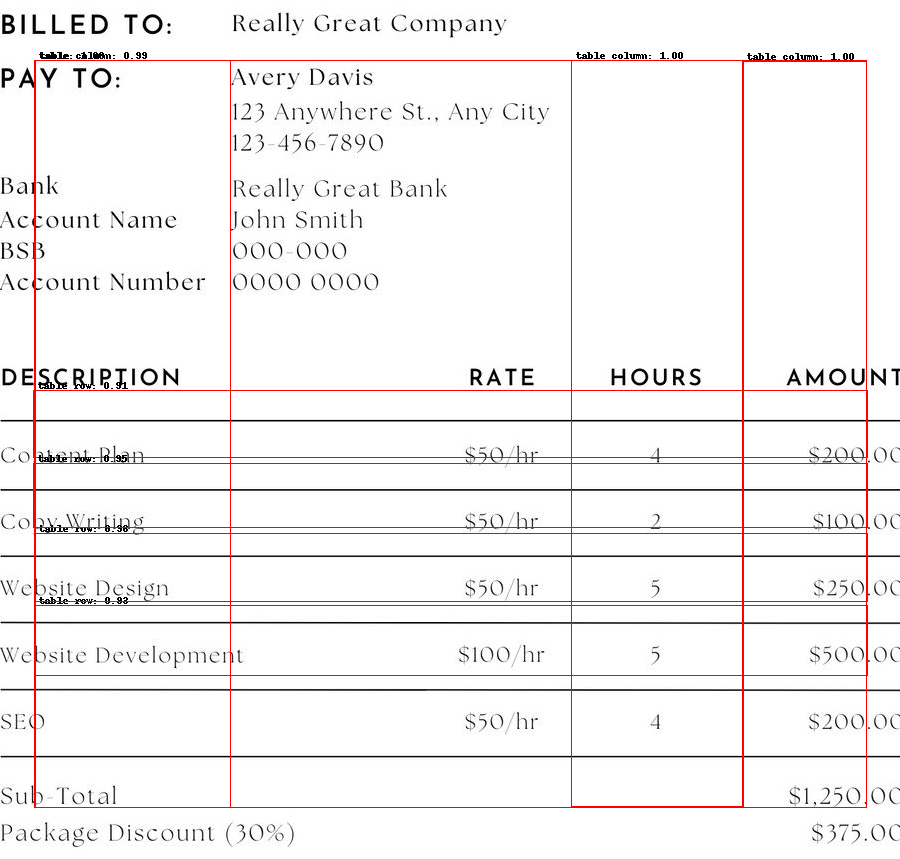

In [38]:
crop_img